# plot Linear policies 

        17 Jun 2023  JMA

In [4]:
import os, re, sys, math, glob
import numpy as np
import pandas as pd
import seaborn as sns
# glob.glob('../Q*')
# os.getcwd()

In [5]:
A = pd.read_csv('../stage/Tsamples-100_step_size-10_max_infection-150_severity_ceiling-120_max_days-100_169-12-44.csv', index_col=0)
A.drop('QN', axis=1, inplace=True)

In [6]:
x = A.cohort.map(lambda x: [float(z) for z in re.findall(r'([-\.\d]+)',  x) ]  )
# the DataFrame constructor takes lists
A[['dose', 'daily_change']] = pd.DataFrame(x.to_list())
A.drop('cohort', axis=1, inplace=True)
display(A)

,day_number,infection,severity,outcome,reward,drug,cum_drug,efficacy,dose,daily_change
patient_id,,,,,,,,,,
0,14,96,109.997959,die,-100,0.0,0.112420,0.429257,0.6,-0.20
1,12,106,114.941172,recover,100,0.0,0.167176,0.160210,0.6,-0.20
2,15,96,120.000000,die,-100,0.0,0.030129,-0.043813,0.6,-0.20
3,13,106,97.952604,recover,100,0.0,0.083691,-0.473207,0.6,-0.20
4,12,100,89.895172,recover,100,0.0,0.182915,0.374469,0.6,-0.20
...,...,...,...,...,...,...,...,...,...,...
44095,14,103,107.219685,recover,100,1.2,1.140381,0.176963,0.8,0.15
44096,10,100,63.213712,recover,100,1.2,1.067723,0.475797,0.8,0.15
44097,20,96,120.000000,die,-100,1.2,1.194100,0.110156,0.8,0.15


In [7]:
# Compute each cohort survival rate

cohorts = A.groupby(['dose', 'daily_change']).agg(lambda z: sum(z >0))
cohorts['survival'] = cohorts.reward / cohorts.day_number   # Divide by any column with positive values to get the count
cohorts.reset_index(inplace=True)
display(cohorts)

/tmp/ipykernel_499/1942202899.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  cohorts = A.groupby(['dose', 'daily_change']).agg(lambda z: sum(z >0))


,dose,daily_change,day_number,infection,severity,reward,drug,cum_drug,efficacy,survival
0,0.6,-0.2000,100,100,100,55,0,100,60,0.55
1,0.6,-0.1825,100,100,100,61,0,100,62,0.61
2,0.6,-0.1650,100,100,100,53,0,100,45,0.53
3,0.6,-0.1475,100,100,100,67,4,100,49,0.67
4,0.6,-0.1300,100,100,100,63,1,100,41,0.63
...,...,...,...,...,...,...,...,...,...,...
436,0.8,0.0800,100,100,100,67,100,100,52,0.67
437,0.8,0.0975,100,100,100,77,100,100,55,0.77
438,0.8,0.1150,100,100,100,62,100,100,62,0.62
439,0.8,0.1325,100,100,100,54,100,100,50,0.54


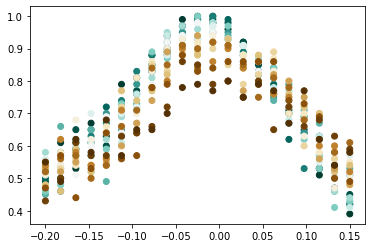

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import random

clrs = cm.get_cmap('plasma', 21)

plotable = cohorts[['dose', 'daily_change', 'survival']]
#plotable['dose'] = plotable['dose'].astype(str)
#plotable['survival'] = plotable['survival'].apply(lambda z: z +random.uniform(-0.1, 0.0))
plt.scatter(plotable.daily_change, plotable.survival, marker='o',   c=plotable.dose, cmap='BrBG_r')
#plt.legend()


In [9]:
plotable.dose.unique()

array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ])

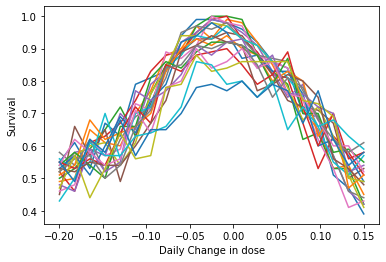

In [10]:
fig, ax1 = plt.subplots()
for d in plotable.dose.unique():
    plt.plot(plotable.loc[plotable.dose == d,'daily_change'], plotable.loc[plotable.dose == d,'survival'], '-')
ax1.set_xlabel('Daily Change in dose')
ax1.set_ylabel('Survival')
plt.show()

Quadratic max at 0.608


Text(0.6080244074991128, 0.8, '  Max: 0.608')

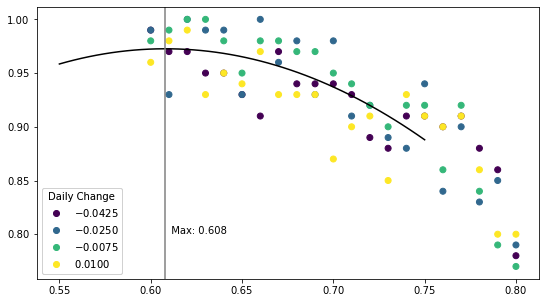

In [43]:
#display(plotable.sort_values('survival', ascending=False))
near_max = plotable.loc[(plotable.daily_change <= 0.02) & (plotable.daily_change > -0.06 ),:]
p3 = np.polyfit(near_max.dose, near_max.survival, 2)
x_dose = np.linspace(0.55, 0.75)
y_func = np.poly1d(p3)
quadratic_max = - p3[1]/(2 * p3[0])
print(f'Quadratic max at {quadratic_max:.3}')

fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(5)
sc = ax.scatter(near_max.dose, near_max.survival, c=near_max.daily_change)
ax.plot(x_dose, y_func(x_dose), 'black')
ax1.set_xlabel('Avg dose')
ax1.set_ylabel('Survival')
legend1 = ax.legend(*sc.legend_elements(),
                    loc="lower left", title="Daily Change")
ax.add_artist(legend1)
ax.axvline(quadratic_max, color='grey')
ax.text(quadratic_max, 0.8, f'  Max: {quadratic_max:.3}')

-0.6075294461493504